INFO:__main__:
Fitting with poisson likelihood:
INFO:__main__:Estimated parameters:
INFO:__main__:beta: 0.399860
INFO:__main__:gamma: 0.246770
INFO:__main__:k: 80256.568562
INFO:__main__:Final negative log-likelihood: -219911.211253


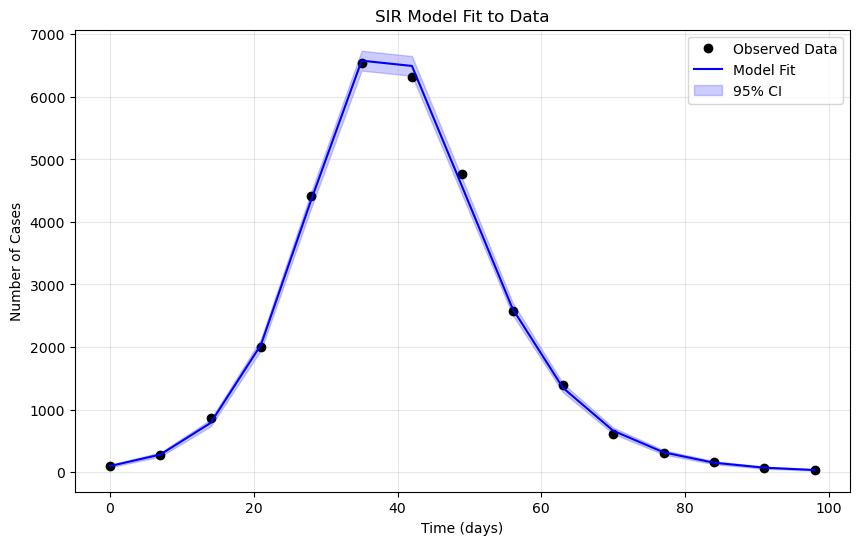

INFO:__main__:
Fitting with ols likelihood:
INFO:__main__:Estimated parameters:
INFO:__main__:beta: 0.383430
INFO:__main__:gamma: 0.230008
INFO:__main__:k: 72438.977602
INFO:__main__:Final negative log-likelihood: 82190.033760


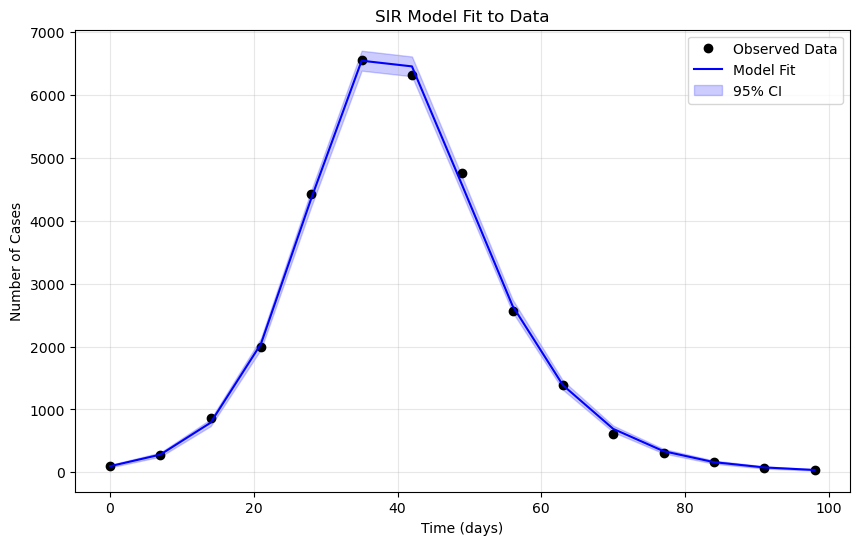

INFO:__main__:
Fitting with wls likelihood:
INFO:__main__:Estimated parameters:
INFO:__main__:beta: 0.400491
INFO:__main__:gamma: 0.247431
INFO:__main__:k: 80518.414190
INFO:__main__:Final negative log-likelihood: 28.283205


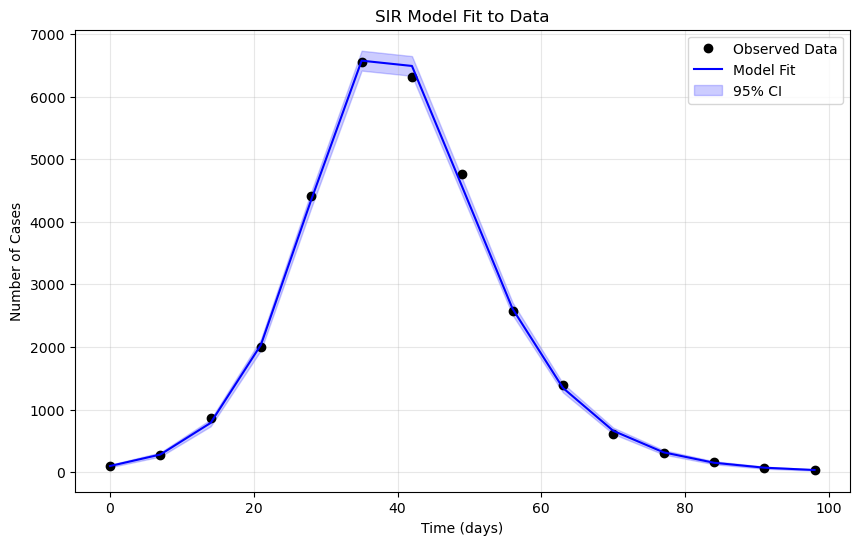

INFO:__main__:
Fitting with extended likelihood:
INFO:__main__:Estimated parameters:
INFO:__main__:beta: 0.399539
INFO:__main__:gamma: 0.246433
INFO:__main__:k: 80122.873867
INFO:__main__:Final negative log-likelihood: 28.914472


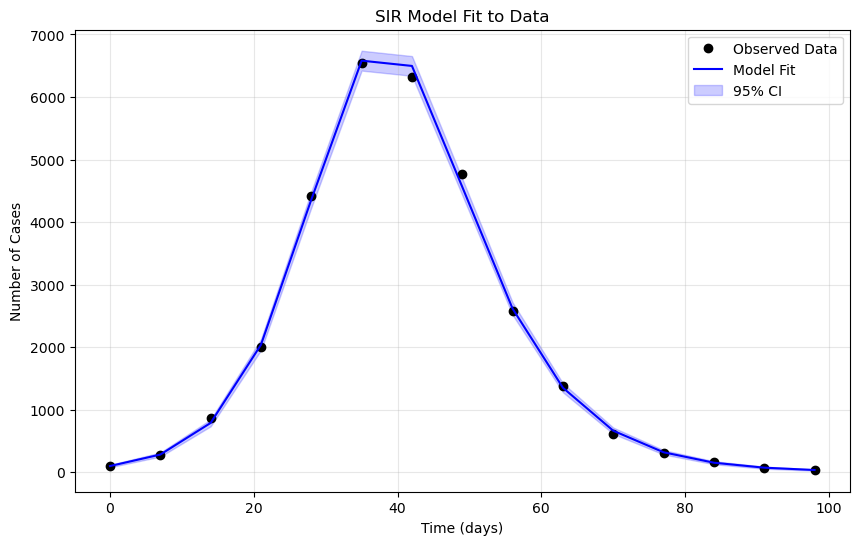

In [1]:
#!/usr/bin/env python3
"""
Improved SIR (Susceptible-Infected-Recovered) Model Implementation
"""

import numpy as np
from scipy.integrate import odeint
from scipy.optimize import minimize
from scipy.stats import poisson, norm
import matplotlib.pyplot as plt
from typing import List, Tuple, Callable
import logging

# Configure logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

class SIRModel:
    def __init__(self, times: List[float], data: List[float], initial_params: List[float]):
        """
        Initialize SIR model with data and parameters
        
        Args:
            times: List of time points
            data: List of observed infection counts
            initial_params: [beta, gamma, k] where:
                beta: infection rate
                gamma: recovery rate
                k: reporting rate * total population
        """
        self.times = np.array(times)
        self.data = np.array(data)
        self.params = np.array(initial_params)
        self.param_names = ['beta', 'gamma', 'k']
        
    def model(self, state: np.ndarray, t: float, params: np.ndarray) -> np.ndarray:
        """
        SIR model differential equations
        """
        S, I, R = state
        beta, gamma, _ = params
        mu = 0  # Birth/death rate (assumed 0 for short-term epidemics)
        
        dSdt = mu - beta * S * I - mu * S
        dIdt = beta * S * I - gamma * I - mu * I
        dRdt = gamma * I - mu * R
        
        return np.array([dSdt, dIdt, dRdt])

    def get_initial_conditions(self, params: np.ndarray) -> np.ndarray:
        """Calculate initial conditions based on first data point"""
        S0 = 1.0 - (self.data[0] / params[2])
        I0 = self.data[0] / params[2]
        R0 = 0.0
        return np.array([S0, I0, R0])

    def measurement_function(self, states: np.ndarray, params: np.ndarray) -> np.ndarray:
        """Convert model states to observable measurements"""
        return states[:, 1] * params[2]

    def simulate(self, params: np.ndarray) -> np.ndarray:
        """Simulate the model with given parameters"""
        try:
            initial_conditions = self.get_initial_conditions(params)
            solution = odeint(self.model, initial_conditions, self.times, args=(params,))
            return self.measurement_function(solution, params)
        except Exception as e:
            logger.error(f"Simulation failed: {str(e)}")
            raise

    def negative_log_likelihood(self, params: np.ndarray, 
                              likelihood_type: str = 'poisson') -> float:
        """
        Calculate negative log-likelihood for different error models
        
        Args:
            params: Model parameters
            likelihood_type: One of ['poisson', 'ols', 'wls', 'extended']
        """
        params = np.abs(params)  # Ensure positive parameters
        
        try:
            y_model = self.simulate(params)
            
            if likelihood_type == 'poisson':
                return np.sum(y_model) - np.sum(self.data * np.log(y_model))
            
            elif likelihood_type == 'ols':
                return np.sum((self.data - y_model) ** 2)
            
            elif likelihood_type == 'wls':
                # Weighted least squares with Poisson-style variance
                return np.sum((self.data - y_model) ** 2 / self.data)
            
            elif likelihood_type == 'extended':
                # Extended least squares using model prediction variance
                return np.sum((self.data - y_model) ** 2 / y_model)
            
            else:
                raise ValueError(f"Unknown likelihood type: {likelihood_type}")
                
        except Exception as e:
            logger.error(f"Likelihood calculation failed: {str(e)}")
            return np.inf

    def fit(self, likelihood_type: str = 'poisson') -> Tuple[np.ndarray, float]:
        """
        Fit model to data using maximum likelihood estimation
        
        Returns:
            Tuple of (estimated parameters, final negative log-likelihood)
        """
        try:
            objective = lambda p: self.negative_log_likelihood(p, likelihood_type)
            
            result = minimize(
                objective,
                self.params,
                method='Nelder-Mead',
                options={'maxiter': 10000}
            )
            
            if not result.success:
                logger.warning(f"Optimization failed: {result.message}")
                
            self.params = np.abs(result.x)
            return self.params, result.fun
            
        except Exception as e:
            logger.error(f"Model fitting failed: {str(e)}")
            raise

    def plot_fit(self, show_confidence: bool = False) -> None:
        """Plot the model fit against data"""
        plt.figure(figsize=(10, 6))
        
        # Plot data points
        plt.plot(self.times, self.data, 'ko', label='Observed Data')
        
        # Plot model prediction
        y_model = self.simulate(self.params)
        plt.plot(self.times, y_model, 'b-', label='Model Fit')
        
        if show_confidence:
            # Add confidence intervals (assuming Poisson variance)
            ci = 1.96 * np.sqrt(y_model)  # 95% CI
            plt.fill_between(
                self.times,
                y_model - ci,
                y_model + ci,
                color='b',
                alpha=0.2,
                label='95% CI'
            )
        
        plt.xlabel('Time (days)')
        plt.ylabel('Number of Cases')
        plt.title('SIR Model Fit to Data')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()

def main():
    # Example usage
    times = [0, 7, 14, 21, 28, 35, 42, 49, 56, 63, 70, 77, 84, 91, 98]
    data = [97, 271, 860, 1995, 4419, 6549, 6321, 4763, 2571, 1385, 615, 302, 159, 72, 34]
    initial_params = [0.4, 0.25, 80000.0]  # [beta, gamma, k]

    # Create and fit model
    model = SIRModel(times, data, initial_params)
    
    # Fit using different likelihood functions
    likelihood_types = ['poisson', 'ols', 'wls', 'extended']
    
    for likelihood_type in likelihood_types:
        try:
            logger.info(f"\nFitting with {likelihood_type} likelihood:")
            params, nll = model.fit(likelihood_type)
            
            logger.info("Estimated parameters:")
            for name, value in zip(model.param_names, params):
                logger.info(f"{name}: {value:.6f}")
            logger.info(f"Final negative log-likelihood: {nll:.6f}")
            
            # Plot results
            model.plot_fit(show_confidence=True)
            
        except Exception as e:
            logger.error(f"Failed to fit {likelihood_type} model: {str(e)}")
            continue

if __name__ == "__main__":
    main()